In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import datetime
import time

In [2]:
NORS_df = pd.read_csv('../data/NORS.csv')

C:\Users\rayna\AppData\Local\Temp\ipykernel_27852\874844664.py:1: DtypeWarning: Columns (8,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  NORS_df = pd.read_csv('../data/NORS.csv')


In [3]:
NORS_df.head()

,Year,Month,State,Primary Mode,Etiology,Serotype or Genotype,Etiology Status,Setting,Illnesses,Hospitalizations,Info On Hospitalizations,Deaths,Info On Deaths,Food Vehicle,Food Contaminated Ingredient,IFSAC Category,Water Exposure,Water Type,Animal Type
0,1971,2,California,Water,Copper,NaN,Confirmed,Restaurant,2,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Community,NaN
1,1971,6,Arkansas,Water,Hepatitis A,NaN,Confirmed,Store,98,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Other,NaN
2,1971,6,Missouri,Water,Unknown,NaN,Suspected,Subdivision/Neighborhood,2,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Community,NaN
3,1971,6,Alabama,Water,Selenium,NaN,Confirmed,Unknown,3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Individual/Private,NaN
4,1971,6,Vermont,Water,Unknown,NaN,Suspected,Community/municipality,3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Community,NaN


In [4]:
NORS_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66713 entries, 0 to 66712
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Year                          66713 non-null  int64  
 1   Month                         66713 non-null  int64  
 2   State                         66713 non-null  object 
 3   Primary Mode                  66713 non-null  object 
 4   Etiology                      50375 non-null  object 
 5   Serotype or Genotype          16470 non-null  object 
 6   Etiology Status               50375 non-null  object 
 7   Setting                       60804 non-null  object 
 8   Illnesses                     66713 non-null  object 
 9   Hospitalizations              58155 non-null  float64
 10  Info On Hospitalizations      58480 non-null  object 
 11  Deaths                        58785 non-null  float64
 12  Info On Deaths                58463 non-null  object 
 13  F

The data seems fairly clean for the most part, while some columns seem to have a lot of missing values there is a good chance that it is simply because those columns are about specific outbreak types(foodborne, water, animal). I will need to see if there are any duplicate rows and if there are drop them, combine the Year and Month columns and make the Dtype for the new column DateTime, and correct a couple other Dtypes, but overall I don't expect to have to do a lot of cleaning for this dataset until I get it ready to set up in SQLite.

In [5]:
NORS_df.duplicated().sum()

np.int64(1421)

In [6]:
NORS_df['Primary Mode'].unique()

array(['Water', 'Food', 'Person-to-person', 'Indeterminate/unknown',
       'Animal contact',
       'Environmental contamination other than food/water'], dtype=object)

In [7]:
NORS_df.loc[NORS_df['Primary Mode'] == 'Environmental contamination other than food/water', 'Primary Mode'] = 'Other'
NORS_df['Primary Mode'].unique()
#I do not like using .loc in the slightest, I would have used .replace but my system did not like that

array(['Water', 'Food', 'Person-to-person', 'Indeterminate/unknown',
       'Animal contact', 'Other'], dtype=object)

In [8]:
duplicated_rows = NORS_df[NORS_df.duplicated()]
print(duplicated_rows)

       Year  Month           State           Primary Mode           Etiology  \
521    1983      7       Minnesota                  Water  Norovirus unknown   
1037   1998      1            Ohio                   Food                NaN   
1049   1998      1      Washington                   Food                NaN   
1054   1998      1            Ohio                   Food                NaN   
1101   1998      1         Florida                   Food                NaN   
...     ...    ...             ...                    ...                ...   
66395  2023     11  South Carolina       Person-to-person  Norovirus unknown   
66473  2023     12       Wisconsin       Person-to-person  Norovirus unknown   
66532  2023     12            Iowa  Indeterminate/unknown                NaN   
66660  2023     12       Minnesota       Person-to-person  Norovirus unknown   
66661  2023     12       Minnesota       Person-to-person  Norovirus unknown   

      Serotype or Genotype Etiology Sta

In [9]:
NORS_df.drop_duplicates(keep='first', inplace=True)
NORS_df.duplicated().sum()

np.int64(0)

In [10]:
NORS_df['Etiology Status'].unique()

array(['Confirmed', 'Suspected', nan, 'Suspected;Confirmed',
       'Confirmed;Confirmed', 'Confirmed;Confirmed;Suspected;Suspected',
       'Confirmed;Suspected', 'Confirmed;Confirmed;Confirmed',
       'Suspected;Suspected;Confirmed',
       'Confirmed;Confirmed;Confirmed;Confirmed',
       'Suspected;Suspected;Confirmed;Suspected', 'Suspected;Suspected',
       'Suspected;Suspected;Confirmed;Confirmed',
       'Suspected;Suspected;Suspected;Confirmed',
       'Suspected;Confirmed;Suspected',
       'Suspected;Suspected;Suspected;Suspected',
       'Confirmed;Confirmed;Suspected', 'Suspected;Suspected;Suspected',
       'Confirmed;Confirmed;Confirmed;Confirmed;Confirmed;Confirmed',
       'Confirmed;Confirmed;Confirmed;Confirmed;Confirmed',
       'Confirmed;Suspected;Confirmed;Confirmed',
       'Suspected;Confirmed;Confirmed',
       'Confirmed;Confirmed;Confirmed;Confirmed;Suspected',
       'Suspected;Confirmed;Confirmed;Confirmed;Confirmed;Confirmed;Confirmed',
       'Confirmed

Due to the way these values have been entered in, there isno way to know whether or not the mixed values were meant to be confirmed or suspected, but based on what I saw with NORS_df.info() and comparing the etiology_status and etiology columns, I can reasonably assume that they were meant to me confirmed.

In [11]:
NORS_df = NORS_df.loc[NORS_df['Etiology Status'].notna()]
NORS_df.loc[NORS_df['Etiology Status'].str.contains('confirmed', case=False), 'Etiology Status'] = 'Confirmed'
NORS_df.loc[NORS_df['Etiology Status'].str.contains('suspected', case=False), 'Etiology Status'] = 'Suspected'
NORS_df['Etiology Status'].unique()

array(['Confirmed', 'Suspected'], dtype=object)

In [12]:
NORS_df['Month'] = NORS_df['Month'].astype('str').replace({'1': '01', '2': '02', '3': '03', '4': '04', '5': '05', '6': '06', '7': '07', '8': '08', '9': '09'})
NORS_df.head()

,Year,Month,State,Primary Mode,Etiology,Serotype or Genotype,Etiology Status,Setting,Illnesses,Hospitalizations,Info On Hospitalizations,Deaths,Info On Deaths,Food Vehicle,Food Contaminated Ingredient,IFSAC Category,Water Exposure,Water Type,Animal Type
0,1971,02,California,Water,Copper,NaN,Confirmed,Restaurant,2,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Community,NaN
1,1971,06,Arkansas,Water,Hepatitis A,NaN,Confirmed,Store,98,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Other,NaN
2,1971,06,Missouri,Water,Unknown,NaN,Suspected,Subdivision/Neighborhood,2,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Community,NaN
3,1971,06,Alabama,Water,Selenium,NaN,Confirmed,Unknown,3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Individual/Private,NaN
4,1971,06,Vermont,Water,Unknown,NaN,Suspected,Community/municipality,3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Community,NaN


In [13]:
NORS_df['Date'] = NORS_df['Year'].astype('str') + NORS_df['Month'].astype('str')
NORS_column_to_move = NORS_df.pop('Date')
NORS_df.insert(0, 'Date', NORS_column_to_move)
NORS_df.drop(columns=['Year', 'Month'], inplace= True)
NORS_df.head()

,Date,State,Primary Mode,Etiology,Serotype or Genotype,Etiology Status,Setting,Illnesses,Hospitalizations,Info On Hospitalizations,Deaths,Info On Deaths,Food Vehicle,Food Contaminated Ingredient,IFSAC Category,Water Exposure,Water Type,Animal Type
0,197102,California,Water,Copper,NaN,Confirmed,Restaurant,2,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Community,NaN
1,197106,Arkansas,Water,Hepatitis A,NaN,Confirmed,Store,98,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Other,NaN
2,197106,Missouri,Water,Unknown,NaN,Suspected,Subdivision/Neighborhood,2,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Community,NaN
3,197106,Alabama,Water,Selenium,NaN,Confirmed,Unknown,3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Individual/Private,NaN
4,197106,Vermont,Water,Unknown,NaN,Suspected,Community/municipality,3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Community,NaN


In [14]:
NORS_df['Date'] = pd.to_datetime(NORS_df['Date'].astype(str) + '01', format='%Y%m%d')
NORS_df['Date'] = NORS_df['Date'].dt.strftime('%Y-%m')
NORS_df.head()

,Date,State,Primary Mode,Etiology,Serotype or Genotype,Etiology Status,Setting,Illnesses,Hospitalizations,Info On Hospitalizations,Deaths,Info On Deaths,Food Vehicle,Food Contaminated Ingredient,IFSAC Category,Water Exposure,Water Type,Animal Type
0,1971-02,California,Water,Copper,NaN,Confirmed,Restaurant,2,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Community,NaN
1,1971-06,Arkansas,Water,Hepatitis A,NaN,Confirmed,Store,98,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Other,NaN
2,1971-06,Missouri,Water,Unknown,NaN,Suspected,Subdivision/Neighborhood,2,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Community,NaN
3,1971-06,Alabama,Water,Selenium,NaN,Confirmed,Unknown,3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Individual/Private,NaN
4,1971-06,Vermont,Water,Unknown,NaN,Suspected,Community/municipality,3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Community,NaN


In [15]:
NORS_df.drop('Serotype or Genotype', axis=1, inplace=True)
NORS_df.head()
#Looking at the data, there aren't enough rows that don't have null values to make it worth keeping.

,Date,State,Primary Mode,Etiology,Etiology Status,Setting,Illnesses,Hospitalizations,Info On Hospitalizations,Deaths,Info On Deaths,Food Vehicle,Food Contaminated Ingredient,IFSAC Category,Water Exposure,Water Type,Animal Type
0,1971-02,California,Water,Copper,Confirmed,Restaurant,2,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Community,NaN
1,1971-06,Arkansas,Water,Hepatitis A,Confirmed,Store,98,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Other,NaN
2,1971-06,Missouri,Water,Unknown,Suspected,Subdivision/Neighborhood,2,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Community,NaN
3,1971-06,Alabama,Water,Selenium,Confirmed,Unknown,3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Individual/Private,NaN
4,1971-06,Vermont,Water,Unknown,Suspected,Community/municipality,3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Community,NaN


I have decided to add two columns, an Outbreak ID number and a Primary Mode ID number, so that it is easier to turn this dataframe into a proper relational database.

In [16]:
NORS_df['Outbreak ID'] = range(1, len(NORS_df) + 1)
NORS_column_to_move_2 = NORS_df.pop('Outbreak ID')
NORS_df.insert(0, 'Outbreak ID', NORS_column_to_move_2)
#This will make it easier to keep track of what information is relevant to what outbreak
NORS_df['Primary Mode ID'] = NORS_df['Primary Mode'].astype('category').cat.codes + 1
NORS_column_to_move_3 = NORS_df.pop('Primary Mode ID')
NORS_df.insert(3, 'Primary Mode ID', NORS_column_to_move_3)
#This will (at least in theory) make it easier to sort things into their rlevant tables by Primary Mode
NORS_df.head()

,Outbreak ID,Date,State,Primary Mode ID,Primary Mode,Etiology,Etiology Status,Setting,Illnesses,Hospitalizations,Info On Hospitalizations,Deaths,Info On Deaths,Food Vehicle,Food Contaminated Ingredient,IFSAC Category,Water Exposure,Water Type,Animal Type
0,1,1971-02,California,6,Water,Copper,Confirmed,Restaurant,2,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Community,NaN
1,2,1971-06,Arkansas,6,Water,Hepatitis A,Confirmed,Store,98,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Other,NaN
2,3,1971-06,Missouri,6,Water,Unknown,Suspected,Subdivision/Neighborhood,2,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Community,NaN
3,4,1971-06,Alabama,6,Water,Selenium,Confirmed,Unknown,3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Individual/Private,NaN
4,5,1971-06,Vermont,6,Water,Unknown,Suspected,Community/municipality,3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Drinking water,Community,NaN


And with that, the inital data cleaning is complete. I may have to do more as I turn everything into SQLite tables and create a relational database, but this is a good starting point.

In [17]:
outbreak_df = NORS_df[['Outbreak ID', 'Date','State', 'Primary Mode ID', 'Etiology','Etiology Status',
                       'Setting','Illnesses','Hospitalizations', 'Info On Hospitalizations', 'Deaths',
                        'Info On Deaths']].drop_duplicates().rename(columns={
    'Outbreak ID': 'outbreak_id',
    'Date':'date',
    'State':'state',
    'Primary Mode ID': 'primary_mode_id',
    'Etiology': 'etiology',
    'Etiology Status':'etiology_status',
    'Setting':'setting',
    'Illnesses':'estimated_total_case_num',
    'Hospitalizations': 'hospitalizations',
    'Info On Hospitalizations': 'hospitalization_info_available',
    'Deaths': 'deaths',
    'Info on Deaths': 'death_info_available'
})

In [18]:
outbreak_df.head()

,outbreak_id,date,state,primary_mode_id,etiology,etiology_status,setting,estimated_total_case_num,hospitalizations,hospitalization_info_available,deaths,Info On Deaths
0,1,1971-02,California,6,Copper,Confirmed,Restaurant,2,NaN,NaN,0.0,NaN
1,2,1971-06,Arkansas,6,Hepatitis A,Confirmed,Store,98,NaN,NaN,0.0,NaN
2,3,1971-06,Missouri,6,Unknown,Suspected,Subdivision/Neighborhood,2,NaN,NaN,0.0,NaN
3,4,1971-06,Alabama,6,Selenium,Confirmed,Unknown,3,NaN,NaN,0.0,NaN
4,5,1971-06,Vermont,6,Unknown,Suspected,Community/municipality,3,NaN,NaN,0.0,NaN


This is going to be the main table used in this dataset, as it has all the information about the outbreaks such as when it happened, where it happened, if it was confirmed or suspected, and more.

In [19]:
mode_df = NORS_df[['Primary Mode ID', 'Primary Mode']].drop_duplicates().rename(columns={
    'Primary Mode ID': 'primary_mode_id',
    'Primary Mode': 'primary_mode'
})
mode_df

,primary_mode_id,primary_mode
0,6,Water
1019,2,Food
15019,5,Person-to-person
15025,3,Indeterminate/unknown
15109,1,Animal contact
16017,4,Other


In [20]:
foodborne_df = (NORS_df[NORS_df['Primary Mode ID'] == 2]
    [['Outbreak ID', 'Primary Mode ID', 'Food Vehicle',
    'Food Contaminated Ingredient', 'IFSAC Category']].drop_duplicates()
    .rename(columns={
        'Outbreak ID': 'outbreak_id',
        'Primary Mode ID': 'primary_mode_id',
        'Food Vehicle': 'food_vehicle',
        'Food Contaminated Ingredient': 'contaminated_ingredient',
        'IFSAC Category': 'IFSAC_category'
    })
)
#I don't think you want to know how long it took me to remember that I could filter like that. It was way too long.
foodborne_df.head()

,outbreak_id,primary_mode_id,food_vehicle,contaminated_ingredient,IFSAC_category
1019,986,2,"tuna, raw;salmon, raw",NaN,Fish
1024,987,2,"eggs, other;cake, tiramisu",NaN,Multiple
1028,988,2,"dips, unspecified",NaN,Multiple
1030,989,2,NaN,NaN,NaN
1032,990,2,"fish, ahi",NaN,Fish


In [21]:
water_df = (NORS_df[NORS_df['Primary Mode ID'] == 6]
    [['Outbreak ID', 'Primary Mode ID', 'Water Exposure', 
    'Water Type']].drop_duplicates()
    .rename(columns={
        'Outbreak ID': 'outbreak_id',
        'Primary Mode ID': 'primary_mode_id',
        'Water Exposure': 'water_exposure',
        'Water Type': 'water_type'
    })
)
water_df.head()

,outbreak_id,primary_mode_id,water_exposure,water_type
0,1,6,Drinking water,Community
1,2,6,Drinking water,Other
2,3,6,Drinking water,Community
3,4,6,Drinking water,Individual/Private
4,5,6,Drinking water,Community


In [22]:
animal_df = (NORS_df[NORS_df['Primary Mode ID'] == 1]
    [['Outbreak ID', 'Primary Mode ID', 'Animal Type']].drop_duplicates()
    .rename(columns={
        'Outbreak ID': 'outbreak_id',
        'Primary Mode ID': 'primary_mode_id',
        'Animal Type': 'animal_type'
    })
)
animal_df.head()

,outbreak_id,primary_mode_id,animal_type
15109,9938,1,Cattle
15386,10141,1,Cattle
15645,10317,1,Poultry
15702,10358,1,"Bird, not including poultry;Lizard;Reptile (ty..."
15929,10489,1,Poultry


With this, I have all my data broken up into their respective dataframes ready to be implemented in SQLite. While I admittedly don't currently plan to use the water or animal dataframes in this particular project, I decided to go ahead and split them up into their own dataframes in case I ever want to use this dataset in another project in the future.

In [23]:
with sqlite3.connect("../data/NORS.db") as conn:
    outbreak_df.to_sql('outbreaks', conn, index=False, if_exists='replace')
    mode_df.to_sql('mode', conn, index=False, if_exists='replace')
    foodborne_df.to_sql('foodborne', conn, index=False, if_exists='replace')
    water_df.to_sql('water', conn, index=False, if_exists='replace')
    animal_df.to_sql('animal', conn, index=False, if_exists='replace')
    conn.commit()

Now that I have everything ready with the NORS database, it's time for me to switch over to preparing my FDA food recall API. I was able to see examples of the results I would get from the API, and as such I decided to make a function to gather as many of the results as I could from the API while staying withing the limits.

In [24]:
def fetch_food_recall_data(api_key):
    base_url = 'https://api.fda.gov/food/enforcement.json'
    all_results = []
    limit = 1000 #number of records that match query, max is 1000
    skip = 0 #allows you to skip this number of record that match the search parameter
    max_skip = 25000 #25000 is the largest allowed skip value for this API
    while True:
        params = {
            'api_key': api_key,
            'limit': limit,
            'skip': skip
        }
        response = requests.get(base_url, params=params)
        if response.status_code != 200:
            print(f"Request failed due to status code {response.status_code}")
            break
        data = response.json()
        if 'results' not in data:
            print("No more results for this API.")
            break
        results = data['results']
        all_results.extend(results)
         #This part is technically not needed but it is nice seeing the progress being made in regards to the data gathering:
        print(f"Fetched {len(results)} records")
        if len(results) < limit or skip == max_skip:
            break
        skip += limit
        time.sleep(0.2) #give short pause to avoid somehow accidentally hitting the 240 request per minute rate limit
    df = pd.json_normalize(all_results)
    return df

While this function was made primarily with this specific API in mind, I can also edit it for use with other APIs for any future projects I make. The purpose of this function is to automate the gathering of the API results so that I can easily convert those results into a csv for cleaning.

In [ ]:
recall_df = fetch_food_recall_data('your key here')

Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records
Fetched 1000 records


In [26]:
recall_df.to_csv('../data/FDA_food_recall.csv', index=False)

In [27]:
pd.read_csv('../data/FDA_food_recall.csv')

,status,city,state,country,classification,product_type,event_id,recalling_firm,address_1,address_2,...,recall_number,product_description,product_quantity,reason_for_recall,recall_initiation_date,center_classification_date,termination_date,report_date,code_info,more_code_info
0,Terminated,Davie,FL,United States,Class II,Food,75272,Pharmatech LLC,4131 SW 47th Ave Ste 1403,NaN,...,F-0276-2017,"CytoDetox, Hydrolyzed Clinoptilolite Fragments...","1,990 bottles",Recall initiated as a precautionary measure du...,20160808,20161025.0,20240923.0,20161102,"UPC No. 632687615989; Lot No. 30661601, Exp. D...",NaN
1,Terminated,Millbrae,CA,United States,Class II,Food,75069,Magic Gourmet Trading Inc,375 Adrian Rd,NaN,...,F-0865-2017,Koi Palace Mini Moon Cake: Single Box - Mini O...,"2 cases (1 pc/bx, 48bx/cs)","Mooncake products, manufactured and distribute...",20160831,20170106.0,20170111.0,20170118,"FG-M1MOT-UW Best by Nov 1, 2016.",NaN
2,Terminated,Miami,FL,United States,Class I,Food,69516,"Oasis Brands, Inc",13439 NW 19 LANE,NaN,...,F-0609-2015,Crema GuateLinda (Guatemalan Style Cream) in i...,144 pieces,Virginia State (VDACS) found Listeria monocyto...,20141010,20141202.0,20170328.0,20141210,UPC 635349 000390 Best By dates: 07/01/14 thr...,NaN
3,Terminated,Pompano Beach,FL,United States,Class I,Food,62750,FreshPoint South Florida,2300 NW 19th St,NaN,...,F-1922-2012,"Yellow Onion. Product is labeled in part: ""*...",7 cases,FreshPoint South Florida is recalling sliced f...,20120727,20120808.0,20141008.0,20120815,Item # 302940.,NaN
4,Terminated,Rancho Dominguez,CA,United States,Class III,Food,85253,"Organic By Nature, Inc.",2610 Homestead Pl,NaN,...,F-0904-2020,Pure Planet Organic Parasite Cleanse; Net Wt....,xx,Firm was notified by supplier that Organic Gro...,20200224,20200413.0,20210202.0,20200401,Lot codes: 72746,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25995,Terminated,Boston,MA,United States,Class III,Food,77570,Channel Fish Processing Co. Inc,18 Food Mart Rd,NaN,...,F-2918-2017,Ocean's Best - Raw Breaded Fish Squares ( 3OZ ...,"1,055,006 pounds (total distributed for all pr...",Products recalled due to undeclared allergen -...,20170613,20170725.0,20170912.0,20170802,"3OZ squares lot #'s - 23567, 22748, 23042 4OZ...",NaN
25996,Terminated,Massillon,OH,United States,Class II,Food,80992,"Shearers Foods, Llc",100 Lincoln Way E,NaN,...,F-1966-2018,White Corn Tortilla Chips packaged under the f...,"6,750 cases total",Corn Chip products are being recalled due to p...,20180907,20180917.0,20200617.0,20180926,"Bag Code Date: 1. 12/31/2018, 2. 12/31/...",NaN
25997,Terminated,Los Angeles,CA,United States,Class II,Food,70776,A I Foods Corporation,1700 N Soto St,NaN,...,F-1935-2015,"Cheesetix (Cheese Lumpia) Pimiento (12.6 oz), ...",20 units,AI Foods is recalling egg roll skins due to un...,20150318,20150409.0,20150724.0,20150415,All,NaN
25998,Terminated,Eden Prairie,MN,United States,Class I,Food,92573,SunOpta Grains and Foods Inc.,7078 Shady Oak Rd,NaN,...,F-1256-2023,Pineapple Chunks packaged under the following ...,"22995 cases + 232,300 lbs. bulk",Fruit products have the potential to be contam...,20230616,20230718.0,20240207.0,20230726,1. Lot / Best By: FED303132 / 01/31/2025; ...,NaN


In [28]:
recall_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26000 entries, 0 to 25999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   status                      26000 non-null  object
 1   city                        26000 non-null  object
 2   state                       26000 non-null  object
 3   country                     26000 non-null  object
 4   classification              26000 non-null  object
 5   product_type                26000 non-null  object
 6   event_id                    26000 non-null  object
 7   recalling_firm              26000 non-null  object
 8   address_1                   26000 non-null  object
 9   address_2                   26000 non-null  object
 10  postal_code                 26000 non-null  object
 11  voluntary_mandated          26000 non-null  object
 12  initial_firm_notification   26000 non-null  object
 13  distribution_pattern        26000 non-null  ob

In [29]:
recall_df.duplicated().sum()

np.int64(0)

Looking at the values, I have a decent idea of how I am going to do this. There are no duplicate rows, and most columns have no null values if any, so that will make cleaning this data a bit quicker and easier. I will likely drop both the product_type and country columns as both columns likely have the same value for every row, which means that they aren't nessecary for this project. I will likely also drop the more_code_info column simply because it it the one column that is over 50% null values. I will have to do a good bit of cleaning the reason_for_recall column, but I hope to be able to make a function to get that cleaned relatively quickly and easily. The last immediate thing I can see here is needing to correct the dtypes for the date columns to datetime, but thankfully that is an easy fix.

In [30]:
recall_df = recall_df[recall_df['country'] == 'United States']

Turns out that unlike what I had predicted earlier, there were countries listed that weren't the US. I have dropped these rows, as the focus of this project will be on the United States.

In [31]:
recall_df.drop(columns=['country', 'product_type', 'address_2', 'more_code_info'], inplace= True)
#Am I doing a lot right now? Yes. Am I going to keep doing it anyways? Also yes.
#The last couple of weeks have been chaotic and busy in the worst ways so now I'm trying to get everything finished last minute.
#I'm not riding the stress express I am the stress express, all hail the glory of way too much caffiene.

In [32]:
recall_df.head()

,status,city,state,classification,event_id,recalling_firm,address_1,postal_code,voluntary_mandated,initial_firm_notification,distribution_pattern,recall_number,product_description,product_quantity,reason_for_recall,recall_initiation_date,center_classification_date,termination_date,report_date,code_info
0,Terminated,Davie,FL,Class II,75272,Pharmatech LLC,4131 SW 47th Ave Ste 1403,33314-4036,Voluntary: Firm initiated,Letter,"FL, MI, MS, and OH.",F-0276-2017,"CytoDetox, Hydrolyzed Clinoptilolite Fragments...","1,990 bottles",Recall initiated as a precautionary measure du...,20160808,20161025,20240923,20161102,"UPC No. 632687615989; Lot No. 30661601, Exp. D..."
1,Terminated,Millbrae,CA,Class II,75069,Magic Gourmet Trading Inc,375 Adrian Rd,94030-3104,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...","CA, WA, OR.",F-0865-2017,Koi Palace Mini Moon Cake: Single Box - Mini O...,"2 cases (1 pc/bx, 48bx/cs)","Mooncake products, manufactured and distribute...",20160831,20170106,20170111,20170118,"FG-M1MOT-UW Best by Nov 1, 2016."
2,Terminated,Miami,FL,Class I,69516,"Oasis Brands, Inc",13439 NW 19 LANE,33182,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...","FL, GA. NC, and TN",F-0609-2015,Crema GuateLinda (Guatemalan Style Cream) in i...,144 pieces,Virginia State (VDACS) found Listeria monocyto...,20141010,20141202,20170328,20141210,UPC 635349 000390 Best By dates: 07/01/14 thr...
3,Terminated,Pompano Beach,FL,Class I,62750,FreshPoint South Florida,2300 NW 19th St,33069-5227,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...",Products were distributed in South Florida.,F-1922-2012,"Yellow Onion. Product is labeled in part: ""*...",7 cases,FreshPoint South Florida is recalling sliced f...,20120727,20120808,20141008,20120815,Item # 302940.
4,Terminated,Rancho Dominguez,CA,Class III,85253,"Organic By Nature, Inc.",2610 Homestead Pl,90220-5610,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...","nationwide, Canada and Netherlands",F-0904-2020,Pure Planet Organic Parasite Cleanse; Net Wt....,xx,Firm was notified by supplier that Organic Gro...,20200224,20200413,20210202,20200401,Lot codes: 72746


In [33]:
recall_df['center_classification_date']= pd.to_datetime(recall_df['center_classification_date'], format='%Y%m%d')
recall_df['termination_date']= pd.to_datetime(recall_df['termination_date'], format='%Y%m%d')
recall_df['report_date']= pd.to_datetime(recall_df['report_date'], format='%Y%m%d')
recall_df.head()

,status,city,state,classification,event_id,recalling_firm,address_1,postal_code,voluntary_mandated,initial_firm_notification,distribution_pattern,recall_number,product_description,product_quantity,reason_for_recall,recall_initiation_date,center_classification_date,termination_date,report_date,code_info
0,Terminated,Davie,FL,Class II,75272,Pharmatech LLC,4131 SW 47th Ave Ste 1403,33314-4036,Voluntary: Firm initiated,Letter,"FL, MI, MS, and OH.",F-0276-2017,"CytoDetox, Hydrolyzed Clinoptilolite Fragments...","1,990 bottles",Recall initiated as a precautionary measure du...,20160808,2016-10-25,2024-09-23,2016-11-02,"UPC No. 632687615989; Lot No. 30661601, Exp. D..."
1,Terminated,Millbrae,CA,Class II,75069,Magic Gourmet Trading Inc,375 Adrian Rd,94030-3104,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...","CA, WA, OR.",F-0865-2017,Koi Palace Mini Moon Cake: Single Box - Mini O...,"2 cases (1 pc/bx, 48bx/cs)","Mooncake products, manufactured and distribute...",20160831,2017-01-06,2017-01-11,2017-01-18,"FG-M1MOT-UW Best by Nov 1, 2016."
2,Terminated,Miami,FL,Class I,69516,"Oasis Brands, Inc",13439 NW 19 LANE,33182,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...","FL, GA. NC, and TN",F-0609-2015,Crema GuateLinda (Guatemalan Style Cream) in i...,144 pieces,Virginia State (VDACS) found Listeria monocyto...,20141010,2014-12-02,2017-03-28,2014-12-10,UPC 635349 000390 Best By dates: 07/01/14 thr...
3,Terminated,Pompano Beach,FL,Class I,62750,FreshPoint South Florida,2300 NW 19th St,33069-5227,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...",Products were distributed in South Florida.,F-1922-2012,"Yellow Onion. Product is labeled in part: ""*...",7 cases,FreshPoint South Florida is recalling sliced f...,20120727,2012-08-08,2014-10-08,2012-08-15,Item # 302940.
4,Terminated,Rancho Dominguez,CA,Class III,85253,"Organic By Nature, Inc.",2610 Homestead Pl,90220-5610,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...","nationwide, Canada and Netherlands",F-0904-2020,Pure Planet Organic Parasite Cleanse; Net Wt....,xx,Firm was notified by supplier that Organic Gro...,20200224,2020-04-13,2021-02-02,2020-04-01,Lot codes: 72746


For some reason, I keep getting errors whenever I try to update the dtype for recall_initiation_date, so now I'm going to play around with it and see if I can figure out why.

In [34]:
problem_rows = recall_df.loc[recall_df['recall_initiation_date'] == '02121207']
problem_rows
recall_df.drop(index=21346, inplace=True)

In [35]:
recall_df['recall_initiation_date']= pd.to_datetime(recall_df['recall_initiation_date'], format='%Y%m%d')
recall_df['recall_initiation_date'] = recall_df['recall_initiation_date'].dt.strftime('%Y-%m')
recall_df.head()

,status,city,state,classification,event_id,recalling_firm,address_1,postal_code,voluntary_mandated,initial_firm_notification,distribution_pattern,recall_number,product_description,product_quantity,reason_for_recall,recall_initiation_date,center_classification_date,termination_date,report_date,code_info
0,Terminated,Davie,FL,Class II,75272,Pharmatech LLC,4131 SW 47th Ave Ste 1403,33314-4036,Voluntary: Firm initiated,Letter,"FL, MI, MS, and OH.",F-0276-2017,"CytoDetox, Hydrolyzed Clinoptilolite Fragments...","1,990 bottles",Recall initiated as a precautionary measure du...,2016-08,2016-10-25,2024-09-23,2016-11-02,"UPC No. 632687615989; Lot No. 30661601, Exp. D..."
1,Terminated,Millbrae,CA,Class II,75069,Magic Gourmet Trading Inc,375 Adrian Rd,94030-3104,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...","CA, WA, OR.",F-0865-2017,Koi Palace Mini Moon Cake: Single Box - Mini O...,"2 cases (1 pc/bx, 48bx/cs)","Mooncake products, manufactured and distribute...",2016-08,2017-01-06,2017-01-11,2017-01-18,"FG-M1MOT-UW Best by Nov 1, 2016."
2,Terminated,Miami,FL,Class I,69516,"Oasis Brands, Inc",13439 NW 19 LANE,33182,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...","FL, GA. NC, and TN",F-0609-2015,Crema GuateLinda (Guatemalan Style Cream) in i...,144 pieces,Virginia State (VDACS) found Listeria monocyto...,2014-10,2014-12-02,2017-03-28,2014-12-10,UPC 635349 000390 Best By dates: 07/01/14 thr...
3,Terminated,Pompano Beach,FL,Class I,62750,FreshPoint South Florida,2300 NW 19th St,33069-5227,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...",Products were distributed in South Florida.,F-1922-2012,"Yellow Onion. Product is labeled in part: ""*...",7 cases,FreshPoint South Florida is recalling sliced f...,2012-07,2012-08-08,2014-10-08,2012-08-15,Item # 302940.
4,Terminated,Rancho Dominguez,CA,Class III,85253,"Organic By Nature, Inc.",2610 Homestead Pl,90220-5610,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...","nationwide, Canada and Netherlands",F-0904-2020,Pure Planet Organic Parasite Cleanse; Net Wt....,xx,Firm was notified by supplier that Organic Gro...,2020-02,2020-04-13,2021-02-02,2020-04-01,Lot codes: 72746


I chose to format the recall_initiation_date in %Y%m fomat for the sole purpose of making a join between my two databases.

In [36]:
def standardize_recall_reasons(recall_df, column='reason_for_recall'):
    rules = {
        'Listeria': 'Listeria',
        'Salmonella': 'Salmonella',
        'E. coli': 'E. coli',
        'Norovirus': 'Norovirus',
        'Cyclospora': 'Cyclospora',
        'coliform': 'Coliforms',
        'Pseudomonas fluorescens': 'Pseudomonas fluorescens',
        'aflatoxin': 'Aflatoxin',
        'arsenic': 'Arsenic',
        'lead': 'Lead',
        'pesticide': 'Pesticide Contamination',
        'allergen': 'Allergen',
        'declare': 'Undeclared Ingredient',
        'incorrect ingredient': 'Incorrect Ingredients',
        'incorrect ingredients': 'Incorrect Ingredients',
        'incorrectly identifies': 'Incorrect Ingredients',
        'ingredient statement': 'Incorrect Ingredient Statement',
        'contains statement': 'Incorrect Contains Statement',
        'foreign object': 'Foreign Object',
        'foreign material': 'Foreign Material',
        'metal': 'Metal',
        'plastic': 'Foreign Material',
        'glass': 'Foreign Material',
        'spoiled': 'Spoiled',
        'label': 'Mislabel',
        'Misbranding': 'Mislabel',
        'not listed correctly': 'Mislabel',
        'packaged': 'Mispackaged',
        'may contain': 'Potential Contamination',
        'may have': 'Potential Contamination',
        'contaminated': 'Potential Contamination',
        'contamination': 'Potential Contamination',
        'potential': 'Potential Contamination',
        'prior recall': 'Prior Recall',
        'Missing processing records/production logs': 'Missing Logs',
    }
    uncategorized = pd.Series(True, index=recall_df.index)
    for pattern, replacement in rules.items():
        mask = recall_df[column].str.contains(pattern, case=False, na=False) & uncategorized
        recall_df.loc[mask, column] = replacement
        uncategorized.loc[mask] = False
    recall_df.loc[uncategorized, column] = 'Other'
    return recall_df


recall_df = standardize_recall_reasons(recall_df)
recall_df.head()

,status,city,state,classification,event_id,recalling_firm,address_1,postal_code,voluntary_mandated,initial_firm_notification,distribution_pattern,recall_number,product_description,product_quantity,reason_for_recall,recall_initiation_date,center_classification_date,termination_date,report_date,code_info
0,Terminated,Davie,FL,Class II,75272,Pharmatech LLC,4131 SW 47th Ave Ste 1403,33314-4036,Voluntary: Firm initiated,Letter,"FL, MI, MS, and OH.",F-0276-2017,"CytoDetox, Hydrolyzed Clinoptilolite Fragments...","1,990 bottles",Potential Contamination,2016-08,2016-10-25,2024-09-23,2016-11-02,"UPC No. 632687615989; Lot No. 30661601, Exp. D..."
1,Terminated,Millbrae,CA,Class II,75069,Magic Gourmet Trading Inc,375 Adrian Rd,94030-3104,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...","CA, WA, OR.",F-0865-2017,Koi Palace Mini Moon Cake: Single Box - Mini O...,"2 cases (1 pc/bx, 48bx/cs)",Allergen,2016-08,2017-01-06,2017-01-11,2017-01-18,"FG-M1MOT-UW Best by Nov 1, 2016."
2,Terminated,Miami,FL,Class I,69516,"Oasis Brands, Inc",13439 NW 19 LANE,33182,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...","FL, GA. NC, and TN",F-0609-2015,Crema GuateLinda (Guatemalan Style Cream) in i...,144 pieces,Listeria,2014-10,2014-12-02,2017-03-28,2014-12-10,UPC 635349 000390 Best By dates: 07/01/14 thr...
3,Terminated,Pompano Beach,FL,Class I,62750,FreshPoint South Florida,2300 NW 19th St,33069-5227,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...",Products were distributed in South Florida.,F-1922-2012,"Yellow Onion. Product is labeled in part: ""*...",7 cases,Listeria,2012-07,2012-08-08,2014-10-08,2012-08-15,Item # 302940.
4,Terminated,Rancho Dominguez,CA,Class III,85253,"Organic By Nature, Inc.",2610 Homestead Pl,90220-5610,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...","nationwide, Canada and Netherlands",F-0904-2020,Pure Planet Organic Parasite Cleanse; Net Wt....,xx,Other,2020-02,2020-04-13,2021-02-02,2020-04-01,Lot codes: 72746


This function was made so that I could clean this data quickly and in a structured way. By creating the uncategorized mask, I was able to ensure that every value in the reason_for_recall column had a standardized value, but also ensured that none of the corrected values got changed after they were standardized. Doing it this way ensured that the rows where the value is related to illness didn't risk getting overwritten as the function looped through the list of rules, as the function only edited rows that hadn't had a rule applied to them yet. It also ensures that all of the values I hadn't been able to standardize with the rules still got standardized in a way.

In [37]:
recall_df.head()

,status,city,state,classification,event_id,recalling_firm,address_1,postal_code,voluntary_mandated,initial_firm_notification,distribution_pattern,recall_number,product_description,product_quantity,reason_for_recall,recall_initiation_date,center_classification_date,termination_date,report_date,code_info
0,Terminated,Davie,FL,Class II,75272,Pharmatech LLC,4131 SW 47th Ave Ste 1403,33314-4036,Voluntary: Firm initiated,Letter,"FL, MI, MS, and OH.",F-0276-2017,"CytoDetox, Hydrolyzed Clinoptilolite Fragments...","1,990 bottles",Potential Contamination,2016-08,2016-10-25,2024-09-23,2016-11-02,"UPC No. 632687615989; Lot No. 30661601, Exp. D..."
1,Terminated,Millbrae,CA,Class II,75069,Magic Gourmet Trading Inc,375 Adrian Rd,94030-3104,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...","CA, WA, OR.",F-0865-2017,Koi Palace Mini Moon Cake: Single Box - Mini O...,"2 cases (1 pc/bx, 48bx/cs)",Allergen,2016-08,2017-01-06,2017-01-11,2017-01-18,"FG-M1MOT-UW Best by Nov 1, 2016."
2,Terminated,Miami,FL,Class I,69516,"Oasis Brands, Inc",13439 NW 19 LANE,33182,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...","FL, GA. NC, and TN",F-0609-2015,Crema GuateLinda (Guatemalan Style Cream) in i...,144 pieces,Listeria,2014-10,2014-12-02,2017-03-28,2014-12-10,UPC 635349 000390 Best By dates: 07/01/14 thr...
3,Terminated,Pompano Beach,FL,Class I,62750,FreshPoint South Florida,2300 NW 19th St,33069-5227,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...",Products were distributed in South Florida.,F-1922-2012,"Yellow Onion. Product is labeled in part: ""*...",7 cases,Listeria,2012-07,2012-08-08,2014-10-08,2012-08-15,Item # 302940.
4,Terminated,Rancho Dominguez,CA,Class III,85253,"Organic By Nature, Inc.",2610 Homestead Pl,90220-5610,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...","nationwide, Canada and Netherlands",F-0904-2020,Pure Planet Organic Parasite Cleanse; Net Wt....,xx,Other,2020-02,2020-04-13,2021-02-02,2020-04-01,Lot codes: 72746


In [38]:
recall_df.loc[recall_df['distribution_pattern'].str.contains('nationwide', case=False), 'distribution_pattern'] = 'Nationwide'
recall_df.loc[recall_df['distribution_pattern'].str.contains('New York', case=False), 'distribution_pattern'] = 'NY'
recall_df['distribution_pattern'].value_counts()
#this is to make it easier to join by later, so long as I can join by state its fine so I will leave this column like this

distribution_pattern
Nationwide                                                                                                                                                                                                                                                                                                                                                                                                   4932
NY                                                                                                                                                                                                                                                                                                                                                                                                           1436
The recalled product was distributed to the following states: MD, PA, DE, NY, DC, NJ, NC, CT, SC, VA, MA .                                                                     

In [39]:
recall_df['firm_id'] = recall_df['recalling_firm'].astype('category').cat.codes + 1
recall_df.head()

,status,city,state,classification,event_id,recalling_firm,address_1,postal_code,voluntary_mandated,initial_firm_notification,...,recall_number,product_description,product_quantity,reason_for_recall,recall_initiation_date,center_classification_date,termination_date,report_date,code_info,firm_id
0,Terminated,Davie,FL,Class II,75272,Pharmatech LLC,4131 SW 47th Ave Ste 1403,33314-4036,Voluntary: Firm initiated,Letter,...,F-0276-2017,"CytoDetox, Hydrolyzed Clinoptilolite Fragments...","1,990 bottles",Potential Contamination,2016-08,2016-10-25,2024-09-23,2016-11-02,"UPC No. 632687615989; Lot No. 30661601, Exp. D...",3395
1,Terminated,Millbrae,CA,Class II,75069,Magic Gourmet Trading Inc,375 Adrian Rd,94030-3104,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...",...,F-0865-2017,Koi Palace Mini Moon Cake: Single Box - Mini O...,"2 cases (1 pc/bx, 48bx/cs)",Allergen,2016-08,2017-01-06,2017-01-11,2017-01-18,"FG-M1MOT-UW Best by Nov 1, 2016.",2673
2,Terminated,Miami,FL,Class I,69516,"Oasis Brands, Inc",13439 NW 19 LANE,33182,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...",...,F-0609-2015,Crema GuateLinda (Guatemalan Style Cream) in i...,144 pieces,Listeria,2014-10,2014-12-02,2017-03-28,2014-12-10,UPC 635349 000390 Best By dates: 07/01/14 thr...,3177
3,Terminated,Pompano Beach,FL,Class I,62750,FreshPoint South Florida,2300 NW 19th St,33069-5227,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...",...,F-1922-2012,"Yellow Onion. Product is labeled in part: ""*...",7 cases,Listeria,2012-07,2012-08-08,2014-10-08,2012-08-15,Item # 302940.,1517
4,Terminated,Rancho Dominguez,CA,Class III,85253,"Organic By Nature, Inc.",2610 Homestead Pl,90220-5610,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...",...,F-0904-2020,Pure Planet Organic Parasite Cleanse; Net Wt....,xx,Other,2020-02,2020-04-13,2021-02-02,2020-04-01,Lot codes: 72746,3233


In [40]:
recall_df.describe()

,center_classification_date,termination_date,report_date,firm_id
count,25628,24209,25629,25629.000000
mean,2018-04-14 14:36:25.734353152,2018-09-24 04:09:42.328885760,2018-04-18 12:22:57.127472640,2502.664911
min,2012-06-08 00:00:00,2012-06-08 00:00:00,2012-06-20 00:00:00,1.000000
25%,2015-03-19 12:00:00,2015-12-14 00:00:00,2015-04-01 00:00:00,1353.000000
50%,2017-07-25 00:00:00,2018-01-02 00:00:00,2017-07-26 00:00:00,2416.000000
75%,2021-07-01 00:00:00,2021-07-20 00:00:00,2021-07-07 00:00:00,3723.000000
max,2025-12-11 00:00:00,2025-12-10 00:00:00,2025-12-10 00:00:00,4903.000000
std,NaN,NaN,NaN,1410.596246


In [41]:
food_recall_df = recall_df[['status', 'event_id', 'firm_id', 'classification', 'voluntary_mandated', 'initial_firm_notification', 
                            'distribution_pattern', 'recall_number', 'product_description', 'product_quantity', 'reason_for_recall', 
                            'recall_initiation_date', 'center_classification_date', 'termination_date', 'report_date', 
                            'code_info']].drop_duplicates()
food_recall_df.head()

,status,event_id,firm_id,classification,voluntary_mandated,initial_firm_notification,distribution_pattern,recall_number,product_description,product_quantity,reason_for_recall,recall_initiation_date,center_classification_date,termination_date,report_date,code_info
0,Terminated,75272,3395,Class II,Voluntary: Firm initiated,Letter,"FL, MI, MS, and OH.",F-0276-2017,"CytoDetox, Hydrolyzed Clinoptilolite Fragments...","1,990 bottles",Potential Contamination,2016-08,2016-10-25,2024-09-23,2016-11-02,"UPC No. 632687615989; Lot No. 30661601, Exp. D..."
1,Terminated,75069,2673,Class II,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...","CA, WA, OR.",F-0865-2017,Koi Palace Mini Moon Cake: Single Box - Mini O...,"2 cases (1 pc/bx, 48bx/cs)",Allergen,2016-08,2017-01-06,2017-01-11,2017-01-18,"FG-M1MOT-UW Best by Nov 1, 2016."
2,Terminated,69516,3177,Class I,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...","FL, GA. NC, and TN",F-0609-2015,Crema GuateLinda (Guatemalan Style Cream) in i...,144 pieces,Listeria,2014-10,2014-12-02,2017-03-28,2014-12-10,UPC 635349 000390 Best By dates: 07/01/14 thr...
3,Terminated,62750,1517,Class I,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...",Products were distributed in South Florida.,F-1922-2012,"Yellow Onion. Product is labeled in part: ""*...",7 cases,Listeria,2012-07,2012-08-08,2014-10-08,2012-08-15,Item # 302940.
4,Terminated,85253,3233,Class III,Voluntary: Firm initiated,"Two or more of the following: Email, Fax, Lett...",Nationwide,F-0904-2020,Pure Planet Organic Parasite Cleanse; Net Wt....,xx,Other,2020-02,2020-04-13,2021-02-02,2020-04-01,Lot codes: 72746


In [42]:
company_df = recall_df[['firm_id', 'city', 'state', 'recalling_firm', 'address_1', 'postal_code']].drop_duplicates().rename(columns={
        'address_1': 'address'
    })
company_df.head()

,firm_id,city,state,recalling_firm,address,postal_code
0,3395,Davie,FL,Pharmatech LLC,4131 SW 47th Ave Ste 1403,33314-4036
1,2673,Millbrae,CA,Magic Gourmet Trading Inc,375 Adrian Rd,94030-3104
2,3177,Miami,FL,"Oasis Brands, Inc",13439 NW 19 LANE,33182
3,1517,Pompano Beach,FL,FreshPoint South Florida,2300 NW 19th St,33069-5227
4,3233,Rancho Dominguez,CA,"Organic By Nature, Inc.",2610 Homestead Pl,90220-5610


In [43]:
with sqlite3.connect('../data/FDA_food_recall.db') as conn:
    food_recall_df.to_sql('recalls', conn, index=False, if_exists='replace')
    company_df.to_sql('companies', conn, index=False, if_exists='replace')
    conn.commit()

And with that it is time to start analyzing the data. I will start by analyzing each database seperately before I analyze them together, beginning with my NORS database.

In [44]:
with sqlite3.connect('../data/NORS.db') as conn:
    query_1 = '''select o.etiology, count(o.etiology) as etiology_count
    from outbreaks o
    join foodborne f on o.outbreak_id = f.outbreak_id
    group by o.etiology
    order by etiology_count desc
    limit 10;'''
    result_1 = pd.read_sql(query_1, conn)   
result_1

,etiology,etiology_count
0,Salmonella enterica,3141
1,Norovirus Genogroup I,2878
2,Norovirus Genogroup II,2000
3,Norovirus unknown,1292
4,Clostridium perfringens,921
5,"Escherichia coli, Shiga toxin-producing",708
6,Norovirus,705
7,Staphylococcus aureus,620
8,Scombroid toxin,495
9,Bacillus cereus,399


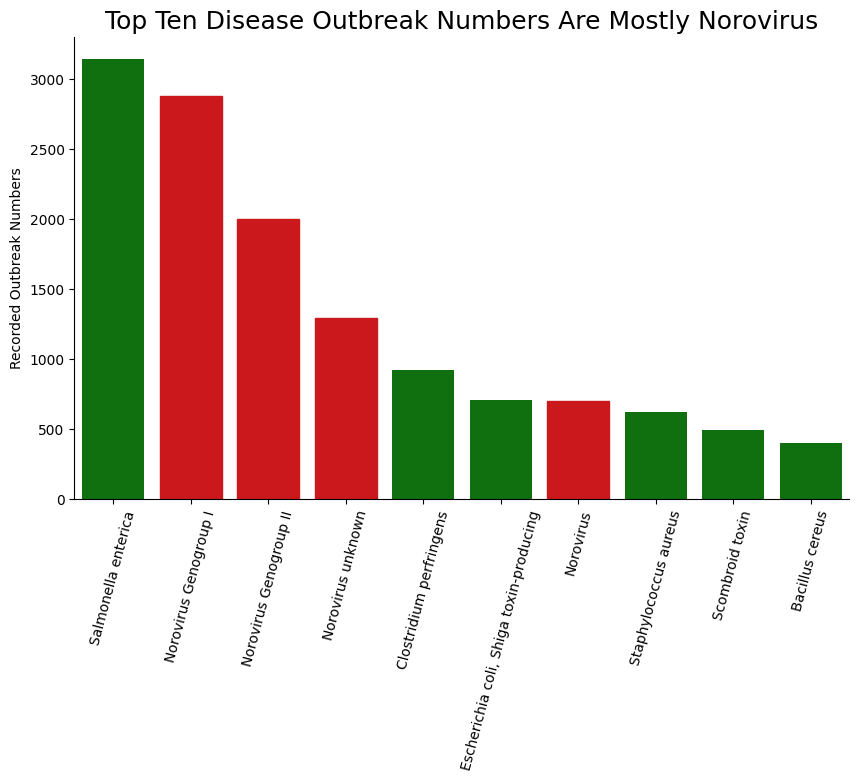

In [105]:
plt.figure(figsize=(10,6))
sns.barplot(result_1, x='etiology', y='etiology_count', color="green", legend=False)
plt.title('Top Ten Disease Outbreak Numbers Are Mostly Norovirus',fontsize=18)
plt.xlabel(None)
plt.ylabel('Recorded Outbreak Numbers')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation= 75)
ax = plt.gca()
noro_color = ['#cb181d', '#cb181d', '#cb181d', '#cb181d']
noro_idx = 0
for bar, label in zip(ax.patches, result_1['etiology']):
    if "Norovirus" in label:
        bar.set_color(noro_color[noro_idx % len(noro_color)])
        noro_idx += 1
sns.despine()
plt.show()

Looking at this, we can see that of the top ten foodborne diseases that show up most frequently in this database, different variations of Norovirus show up under almost half of the listed results.

In [45]:
with sqlite3.connect('../data/NORS.db') as conn:
    query_2 = '''select o.etiology_status, count(o.etiology_status) as status_count
    from outbreaks o
    join foodborne f on o.outbreak_id = f.outbreak_id
    group by o.etiology_status
    order by status_count desc;'''
    result_2 = pd.read_sql(query_2, conn)   
result_2

,etiology_status,status_count
0,Confirmed,10855
1,Suspected,6101


As we can see here, we have significantly more confirmed outbreak cases than suspected cases, which will be helpful as those confirmed cases will be used in the queries where I analyze both databases together.

In [46]:
with sqlite3.connect('../data/NORS.db') as conn:
    query_3 = '''select state, etiology, etiology_count
    from(select o.state, o.etiology, count(o.etiology) as etiology_count,
    row_number() over (partition by o.state
    order by count(o.etiology) desc) as rn
    from outbreaks o
    join foodborne f on o.outbreak_id = f.outbreak_id
    group by o.state, o.etiology)
    where rn = 1
    order by etiology_count desc;'''
    result_3 = pd.read_sql(query_3, conn)   
result_3

,state,etiology,etiology_count
0,California,Norovirus unknown,508
1,Multistate,Salmonella enterica,390
2,Minnesota,Norovirus Genogroup I,331
3,Ohio,Norovirus Genogroup II,240
4,Illinois,Norovirus Genogroup I,227
5,Florida,Staphylococcus aureus,226
6,Wisconsin,Norovirus Genogroup II,157
7,Washington,Norovirus Genogroup I,142
8,Oregon,Norovirus Genogroup I,138
9,New York,Salmonella enterica,131


With this, we can see what disease each state has the most recorded outbreaks of in the data, and we can use that to build some patterns. By looking through the result, we can see that majority of the diseases that are the most common outbreaks in each state are either a form of Norovirus or Salmonella enterica. In combination with our earlier queries, we can see that those two diseases are likely going to be what I will be specifically searching for when I join the NORS database and the FDA food recall dataset to see if there is any potential correlation between the two. I do find it interesting that California ranks higher on this table than the Multistate value by over one hundred outbreaks as that means California had more reported outbreaks of Norovirus than there were reported outbreaks of Salmonella that affected multiple states.

In [106]:
with sqlite3.connect('../data/NORS.db') as conn:
    query_3 = '''select state, etiology, etiology_count
    from(select o.state, o.etiology, count(o.etiology) as etiology_count,
    row_number() over (partition by o.state
    order by count(o.etiology) desc) as rn
    from outbreaks o
    join foodborne f on o.outbreak_id = f.outbreak_id
    group by o.state, o.etiology)
    where rn = 1
    order by etiology_count desc
    limit 10;'''
    limited_result_3 = pd.read_sql(query_3, conn) 

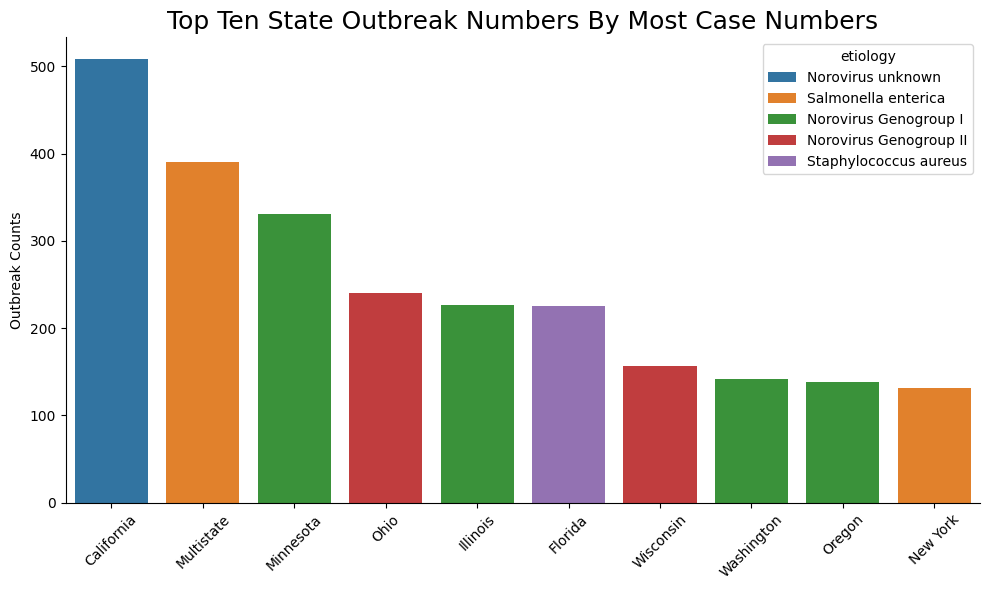

In [108]:
plt.figure(figsize=(10,6))
sns.barplot(limited_result_3, x='state', y='etiology_count', hue= 'etiology')
plt.title('Top Ten State Outbreak Numbers By Most Case Numbers',fontsize=18)
plt.xlabel(None)
plt.ylabel('Outbreak Counts')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation= 45)
sns.despine()
plt.tight_layout()
plt.show()

In [47]:
with sqlite3.connect('../data/NORS.db') as conn: 
    query_4 = '''select substr(o.date, 1, 4) as year, count(o.outbreak_id) as outbreak_count 
    from outbreaks o 
    join foodborne f on o.outbreak_id = f.outbreak_id 
    group by year
    order by year;''' 
    result_4 = pd.read_sql(query_4, conn) 
result_4

,year,outbreak_count
0,1998,535
1,1999,664
2,2000,782
3,2001,775
4,2002,888
5,2003,765
6,2004,939
7,2005,663
8,2006,889
9,2007,729


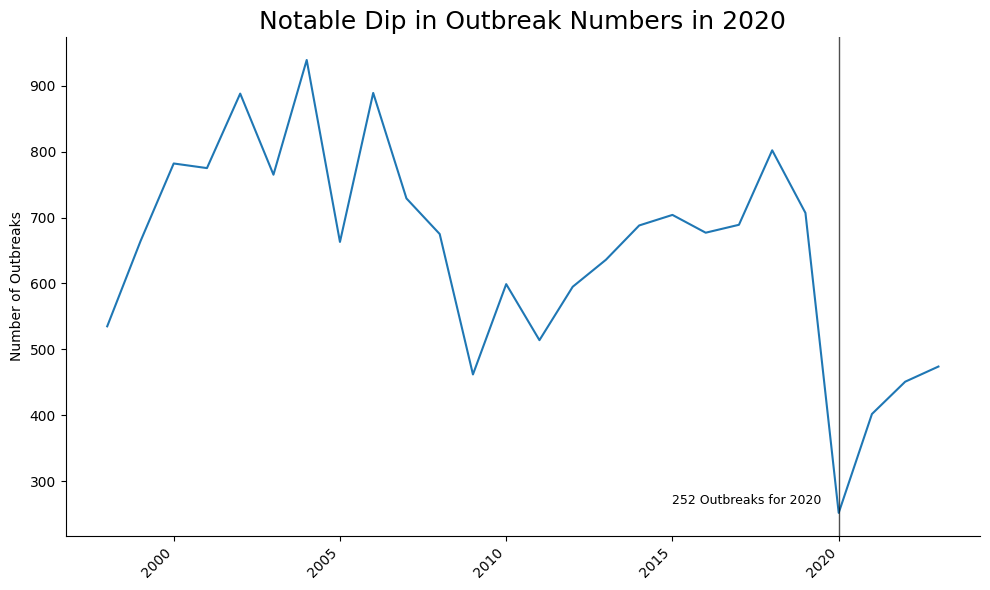

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(result_4, x='year', y='outbreak_count', legend=False)
plt.title('Notable Dip in Outbreak Numbers in 2020', fontsize=18)
plt.xlabel(None)
plt.ylabel('Number of Outbreaks')
ax.axvline(
    2020,
    color= "#040404",
    linewidth = 1,
    alpha = 0.7)
ax.text(
    2015,
    266,
    "252 Outbreaks for 2020",
    color = "#000000",
    fontsize=9
)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
sns.despine()
plt.show()

The results of this query are actually rather interesting to me, for one specific reason. We can see that the normal number of recorded outbreaks per year is in the four hundreds to nine hundreds range, but there was a notable dip in the number of outbreaks in 2020 before it went back to the low end of the normal range. I find this interesting because while if these outbreaks were being spread person-to-person I could attribute it to the pandemic and how we were all isolated to limit the spread of diseases like covid, that can't be the case in this instance as these are specifically outbreaks of foodborne diseases.

In [48]:
with sqlite3.connect('../data/FDA_food_recall.db') as conn:
    query_5 = '''select c.recalling_firm, count(r.event_id) as number_of_recalls
    from companies c
    join recalls r on c.firm_id = r.firm_id
    group by c.recalling_firm
    order by number_of_recalls desc
    limit 10'''
    result_5 = pd.read_sql(query_5, conn)   
result_5

,recalling_firm,number_of_recalls
0,Whole Foods Market,1460
1,Newly Weds Foods Inc,1215
2,"Garden-Fresh Foods, Inc.",1158
3,"Reser's Fine Foods, Inc.",1036
4,Dole Fresh Vegetables Inc,432
5,Target Corporation,378
6,"FRESH IDEATION FOOD GROUP, LLC dba Fresh Creat...",373
7,High Liner Foods Inc.,354
8,"Good Herbs, Inc.",317
9,"C & S Wholesale Grocers, Inc.",301


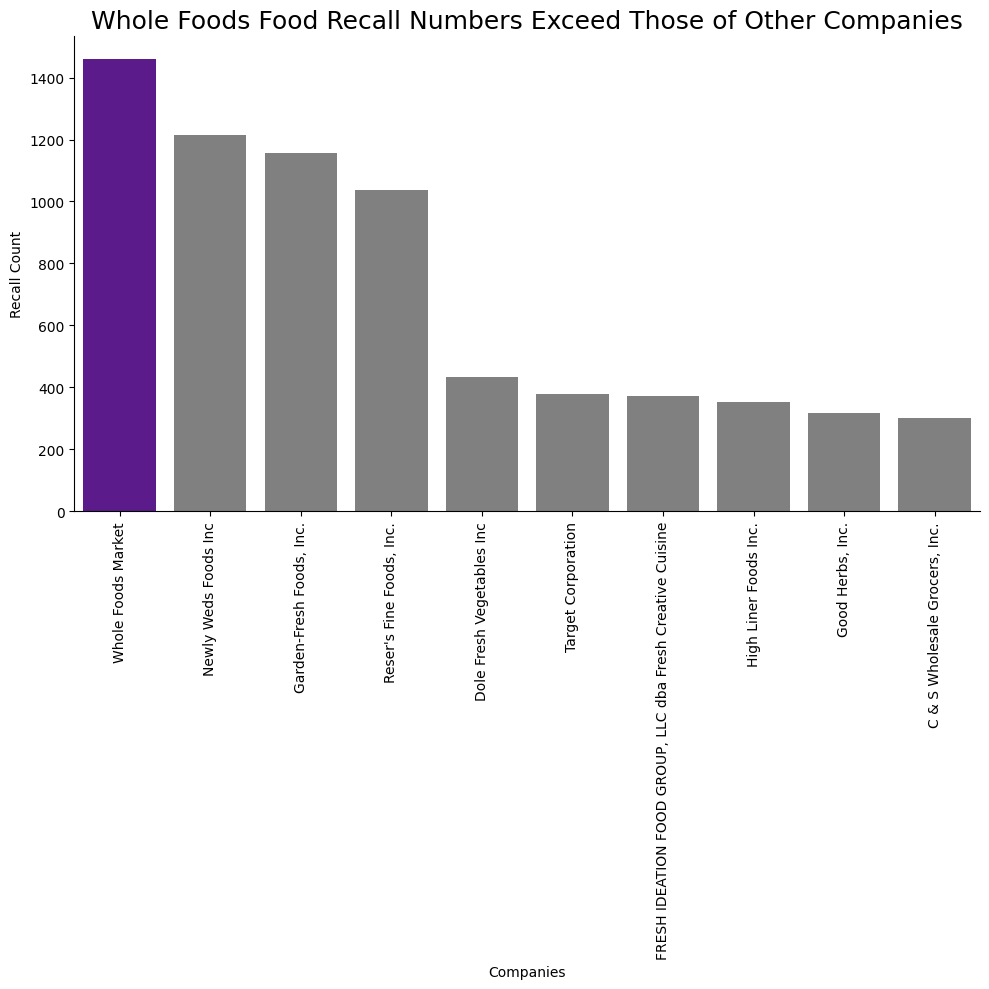

In [117]:
plt.figure(figsize=(10,10))
highlight_company = 'Whole Foods Market'
colors = ["#5F099C" if x == highlight_company else 'grey' for x in result_5['recalling_firm']]
sns.barplot(result_5, x='recalling_firm', y='number_of_recalls', palette= colors, hue= 'recalling_firm', legend=False)
plt.title('Whole Foods Food Recall Numbers Exceed Those of Other Companies',fontsize=18)
plt.xlabel('Companies')
plt.ylabel('Recall Count')
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation= 90)
plt.tight_layout()
sns.despine()
plt.show()

This query was to see which corporations had the highest number of food related recalls, and while I don't recognize most of these corporations I do recognize three larger corporations off the bat, Whole Foods, Dole, and Target. Seeing larger corporations at the top of the list isn't surprising given they sell more products under their brand and hence have a higher likelyhood of needing a product recalled, but it's still an interesting find.

In [49]:
with sqlite3.connect('../data/FDA_food_recall.db') as conn:
    query_6 = '''select substr(recall_initiation_date, 1, 4) as year, count(event_id) as number_of_recalls
    from recalls
    group by year
    order by year;'''
    result_6 = pd.read_sql(query_6, conn)   
result_6

,year,number_of_recalls
0,2008,35
1,2009,17
2,2010,3
3,2011,54
4,2012,1976
5,2013,2209
6,2014,2262
7,2015,2486
8,2016,2824
9,2017,2407


In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(result_6, x='year', y='number_of_recalls', legend=False)
plt.title('Notable Dip in Outbreak Numbers in 2020', fontsize=18)
plt.xlabel(None)
plt.ylabel('Number of Outbreaks')
ax.axvline(
    2020,
    color= "#040404",
    linewidth = 1,
    alpha = 0.7)
ax.text(
    2015,
    266,
    "252 Outbreaks for 2020",
    color = "#000000",
    fontsize=9
)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
sns.despine()
plt.show()

This query was done to see if there were any patterns in how many recalls there are per year. The number of recalls per year was rather low before 2012, which makes sense as 2011 was when the Food Safety Modernization Act (FSMA) passed and gave the FDA the authority to mandate recalls unlike before where recalls were voluntary. While the number of recalls varys year by year, from 2012 onward the number of food recalls has stayed within the one thousand to three thousand range with the numbers typically being below two thousand.

In [72]:
with sqlite3.connect('../data/NORS.db') as conn:
    conn.execute("attach database '../data/FDA_food_recall.db' as fda;")
    joint_query = '''
    select o.date as outbreak_date, o.state as outbreak_state, o.estimated_total_case_num,
    r.recall_initiation_date as recall_date, r.reason_for_recall, r.classification, r.voluntary_mandated, 
    c.recalling_firm
    from outbreaks o
    join foodborne f on o.outbreak_id = f.outbreak_id
    join fda.recalls r on o.date = r.recall_initiation_date
    join fda.companies c on r.firm_id = c.firm_id
    where r.distribution_pattern like '%' || o.state || '%' and o.etiology like '%' || r.reason_for_recall || '%' 
    order by o.date, o.state;'''
    joint_result = pd.read_sql(joint_query, conn)
joint_result.drop_duplicates(inplace=True)
joint_result

,outbreak_date,outbreak_state,estimated_total_case_num,recall_date,reason_for_recall,classification,voluntary_mandated,recalling_firm
0,2012-02,Washington,9,2012-02,Other,Class II,Voluntary: Firm initiated,Daaks International
1,2012-02,Washington,3,2012-02,Other,Class II,Voluntary: Firm initiated,Daaks International
2,2012-05,California,38,2012-05,Salmonella,Class II,Voluntary: Firm initiated,Newly Weds Foods Inc
8,2012-05,California,7,2012-05,Salmonella,Class II,Voluntary: Firm initiated,Newly Weds Foods Inc
14,2012-05,Ohio,2,2012-05,Salmonella,Class II,Voluntary: Firm initiated,Newly Weds Foods Inc
...,...,...,...,...,...,...,...,...
275,2023-09,Minnesota,2,2023-09,Salmonella,Class I,Voluntary: Firm initiated,"Eagle Produce LLC, dba Martori Farms"
276,2023-09,Virginia,10,2023-09,Salmonella,Class I,Voluntary: Firm initiated,"Eagle Produce LLC, dba Martori Farms"
277,2023-09,Washington,2,2023-09,Salmonella,Class I,Voluntary: Firm initiated,"Eagle Produce LLC, dba Martori Farms"
278,2023-09,Wisconsin,5,2023-09,Salmonella,Class I,Voluntary: Firm initiated,"Eagle Produce LLC, dba Martori Farms"


I am both surprised and not to find that this particular query didn't have many results in the end. On one hand, I expected more results since I was looking for outbreaks that could possibly be correlated with any FDA food recalls and not ones outright caused by recalled products, on the other hand it does make sense that I wouldn't be able to find many cases that could have correlation given FDA food recalls are done specifically to lower the chances of if not prevent people from consuming products that would harm themselves and others.

In [ ]:
joint_result['reason_for_recall'].value_counts()

reason_for_recall
Salmonella    101
Other          11
Cyclospora      4
Norovirus       4
Listeria        3
Name: count, dtype: int64

In [76]:
joint_result['voluntary_mandated'].value_counts()

voluntary_mandated
Voluntary: Firm initiated    123
Name: count, dtype: int64

This actually did surprise me a bit. Considering how many Norovirus outbreaks there were listed compared to Salmonella outbreaks, I had been expecting for most of the results I got in the end would have Norovirus as the reason for the recall, but instead it was Salmonella. I do also think its interesting to note that all of these recalls were initiated by the firm and not mandated by the FDA.

In [77]:
joint_result_1 = joint_result['reason_for_recall'].value_counts()